# Competitor analysis: topic modelling of Bauldur's Gate 3 reviews on Steam

## Latent Dirichlet Allocation

In [1]:
# Import packages for LDA 
import pandas as pd
import numpy as np
import json
from datetime import datetime, date
import ast
import re
import nltk
from nltk.corpus import stopwords
from nltk import pos_tag
from nltk.tokenize import word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel, LdaMulticore, Phrases, TfidfModel
from gensim import corpora
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import spacy
from wordcloud import WordCloud
from bs4 import BeautifulSoup
import string
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, PCA, TruncatedSVD
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_absolute_error, make_scorer, f1_score, silhouette_score, adjusted_rand_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.cluster import KMeans, MiniBatchKMeans, DBSCAN
from sklearn.manifold import TSNE
from textblob import TextBlob
from PIL import Image
from dateutil.parser import parse
from IPython.display import display, Markdown
import warnings
from config import BG3_data_file_path

warnings.filterwarnings('ignore')
  

nltk.download('vader_lexicon')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

ImportError: cannot import name 'triu' from 'scipy.linalg' (/Users/paula/Documents/Portfolio/Competitor analysis topic modelling of Bauldurs Gate 3 reviews on Steam/bg3_analysis_env/lib/python3.10/site-packages/scipy/linalg/__init__.py)

In [15]:
# Load data file
file_path = BG3_data_file_path
df = pd.read_csv(file_path)
#Show data frame's first 5 entries
df.head(5)

,recommendationid,author,language,review,timestamp_created,timestamp_updated,voted_up,votes_up,votes_funny,weighted_vote_score,comment_count,steam_purchase,received_for_free,written_during_early_access,hidden_in_steam_china,steam_china_location
0,146197289,"{'steamid': '76561198209057388', 'num_games_ow...",english,my work is really cutting into my Baldur's Gat...,1694565640,1694565640,True,7830,2987,0.980962,0,True,False,False,True,NaN
1,153859247,"{'steamid': '76561198412806684', 'num_games_ow...",english,You can convince bosses to kill themselves. 10/10,1702909919,1702909919,True,3605,900,0.980739,10,True,False,False,True,NaN
2,143924257,"{'steamid': '76561198022720435', 'num_games_ow...",english,Possessed a guard and had them open a gate con...,1691783669,1691783669,True,3124,1268,0.978952,12,True,False,False,True,NaN
3,146776206,"{'steamid': '76561198007607100', 'num_games_ow...",english,I have only one point of criticism:\nThis game...,1695386806,1701885967,True,1320,6,0.978480,28,True,False,False,True,NaN
4,143578821,"{'steamid': '76561198004904749', 'num_games_ow...",english,No microtransactions\nNo in-game purchases\nNo...,1691401740,1691401740,True,15452,51,0.978366,0,True,False,False,True,NaN


In [16]:
# Extract info stored in first column dictionary 
# Convert the 'author' column strings to dictionaries using ast.literal_eval
df['author'] = df['author'].apply(ast.literal_eval)

# Extract 'steamid' from the 'author' dictionaries
df['steamid'] = df['author'].apply(lambda x: x.get('steamid', None))

# Extract 'num_games_owned' from the 'author' dictionaries
df['num_games_owned'] = df['author'].apply(lambda x: x.get('num_games_owned', None))

# Extract 'num_reviews' from the 'author' dictionaries
df['num_reviews'] = df['author'].apply(lambda x: x.get('num_reviews', None))

# Extract 'playtime_forever' from the 'author' dictionaries
df['playtime_forever'] = df['author'].apply(lambda x: x.get('playtime_forever', None)/60)

# Extract 'playtime_at_review' from the 'author' dictionaries
df['playtime_at_review'] = df['author'].apply(lambda x: x.get('playtime_at_review', None)/60)

# Convert 'timestamp_created' to a date in the format YYYY-MM-DD
df['timestamp_created_date'] = pd.to_datetime(df['timestamp_created'], unit='s').dt.strftime('%Y-%m-%d')

# Create a new DataFrame with the specified columns
new_df = df.loc[:,['review','playtime_at_review']]
new_df.head()

,review,playtime_at_review
0,my work is really cutting into my Baldur's Gat...,41.933333
1,You can convince bosses to kill themselves. 10/10,200.900000
2,Possessed a guard and had them open a gate con...,83.833333
3,I have only one point of criticism:\nThis game...,373.150000
4,No microtransactions\nNo in-game purchases\nNo...,27.900000


### EDA

In [19]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   review              500 non-null    object 
 1   playtime_at_review  500 non-null    float64
dtypes: float64(1), object(1)
memory usage: 7.9+ KB


In [27]:
# Are there duplicates? How many?
new_df.duplicated(subset=['review']).sum()

5

In [32]:
# Basic summary statistics
new_df = new_df.drop_duplicates(subset=['review'])
new_df['review_length'] = new_df['review'].str.split().str.len()
new_df.describe()

,playtime_at_review,review_length
count,495.000000,495.000000
mean,115.905051,138.785859
std,153.370717,254.556586
min,0.333333,1.000000
25%,25.608333,12.000000
50%,69.183333,37.000000
75%,152.450000,126.500000
max,1440.983333,1443.000000


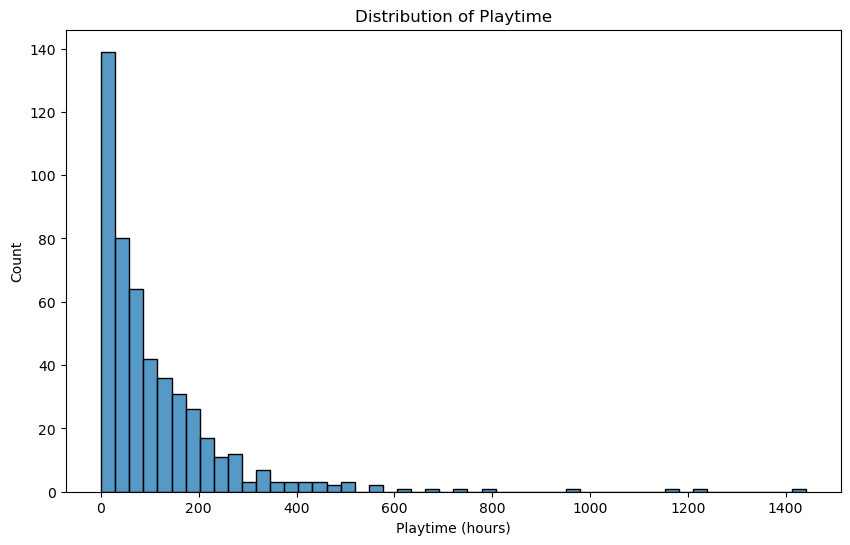

In [33]:
# Playtime distribution
plt.figure(figsize=(10, 6))
sns.histplot(new_df['playtime_at_review'], bins=50)
plt.title('Distribution of Playtime')
plt.xlabel('Playtime (hours)')
plt.show()

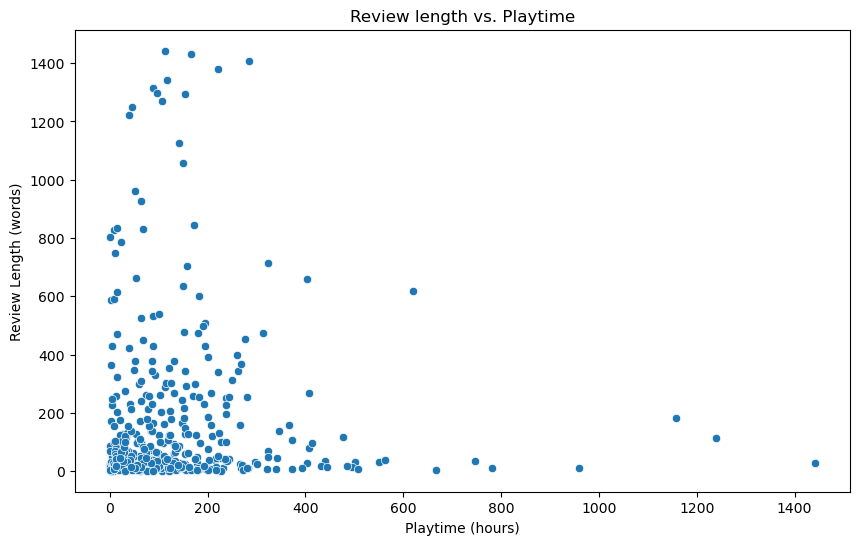

Correlation between review length and playtime: 0.04588988307331036


In [35]:
# Review length vs. playtime at review
plt.figure(figsize=(10, 6))
sns.scatterplot(x='playtime_at_review', y='review_length', data=new_df)
plt.title('Review length vs. Playtime')
plt.xlabel('Playtime (hours)')
plt.ylabel('Review Length (words)')
plt.show()

print(f"Correlation between review length and playtime: {new_df['review_length'].corr(new_df['playtime_at_review'])}")

### Text preprocessing 

In [80]:
# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    
    # Remove URL addresses
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remove non-alphabetic characters (keeping spaces)
    text = re.sub(r'[^a-z\s]', '', text)
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Remove stopwords, lemmatize, and remove isolated letters
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words and len(token) > 1]
    
    # Join tokens back into a string
    return ' '.join(tokens)

# Apply preprocessing to the 'review' column
new_df['processed_review'] = new_df['review'].apply(preprocess_text)

In [81]:
# Visualize the dataframe with new column
new_df.head()

,review,playtime_at_review,review_length,processed_review
0,my work is really cutting into my Baldur's Gat...,41.933333,14,work really cutting baldurs gate time quit
1,You can convince bosses to kill themselves. 10/10,200.900000,8,convince boss kill
2,Possessed a guard and had them open a gate con...,83.833333,40,possessed guard open gate containing giant spi...
3,I have only one point of criticism:\nThis game...,373.150000,107,one point criticism game lack proper ending ep...
4,No microtransactions\nNo in-game purchases\nNo...,27.900000,33,microtransactions ingame purchase paywalls gam...


### Document-term matrix

In [82]:
# Create term frequency matrix
count_vectorizer = CountVectorizer(min_df=0.1, max_df=0.95)
tf_matrix = count_vectorizer.fit_transform(new_df['processed_review'])

# Get feature names (terms)
tf_feature_names = count_vectorizer.get_feature_names_out()

# Create TF-IDF matrix
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(new_df['processed_review'])

# Get feature names (terms) for TF-IDF
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

# Convert sparse matrices to dataframe for easier viewing
tf_df = pd.DataFrame(tf_matrix.toarray(), columns=tf_feature_names)
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_feature_names)

# Print basic information
print("Term Frequency Matrix Shape:", tf_matrix.shape)
print("TF-IDF Matrix Shape:", tfidf_matrix.shape)
print("Number of unique terms:", len(tf_feature_names))

# Display a sample of the TF-IDF matrix (first 5 rows, first 5 columns)
print("\nSample of TF-IDF Matrix:")
print(tfidf_df.iloc[:5, :5])

Term Frequency Matrix Shape: (495, 54)
TF-IDF Matrix Shape: (495, 6186)
Number of unique terms: 54

Sample of TF-IDF Matrix:
   aaa  aaaa  abandoned  ability  able
0  0.0   0.0        0.0      0.0   0.0
1  0.0   0.0        0.0      0.0   0.0
2  0.0   0.0        0.0      0.0   0.0
3  0.0   0.0        0.0      0.0   0.0
4  0.0   0.0        0.0      0.0   0.0


### Explore optimal number of topics

In [83]:
# Convert the preprocessed reviews into a list of lists of words
texts = [review.split() for review in new_df['processed_review']]

# Create a dictionary representation of the documents
dictionary = corpora.Dictionary(texts)

# Create corpus
corpus = [dictionary.doc2bow(text) for text in texts]

### LDA hyperparameter tuning and modeling

In [51]:
def train_lda_model(corpus, dictionary, num_topics, alpha='auto', eta='auto'):
    """
    Train an LDA model with given parameters
    
    Parameters:
    ----------
    corpus : Gensim corpus
    dictionary : Gensim dictionary
    num_topics : int, number of topics
    alpha : float or 'auto', document-topic density
    eta : float or 'auto', topic-word density
    
    Returns:
    -------
    LDA model, coherence score
    """
    model = LdaMulticore(
        corpus=corpus,
        id2word=dictionary,
        num_topics=num_topics,
        random_state=42,
        chunksize=500,
        passes=10,
        alpha=alpha,
        eta=eta,
        workers=2
    )
    
    coherence_model = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    
    return model, coherence_score

# Define the range of topics and hyperparameters to try
num_topics_range = [2, 4, 6, 8, 10]
alpha_values = ['symmetric', 'asymmetric', 0.01, 0.1, 1.0]
eta_values = ['symmetric', 'auto', 0.01, 0.1, 1.0]

# Train models and store results
results = []

for num_topics in num_topics_range:
    for alpha in alpha_values:
        for eta in eta_values:
            model, coherence = train_lda_model(corpus, dictionary, num_topics, alpha, eta)
            results.append({
                'num_topics': num_topics,
                'alpha': alpha,
                'eta': eta,
                'coherence': coherence,
                'model': model
            })

# Find the best model based on coherence score
best_model = max(results, key=lambda x: x['coherence'])

print(f"Best model parameters:")
print(f"Number of topics: {best_model['num_topics']}")
print(f"Alpha: {best_model['alpha']}")
print(f"Eta: {best_model['eta']}")
print(f"Coherence Score: {best_model['coherence']}")

# Print top 10 words for each topic in the best model
best_lda_model = best_model['model']
print("\nTop 10 words for each topic:")
for idx, topic in best_lda_model.print_topics(-1):
    print(f"Topic {idx}: {topic}")

Best model parameters:
Number of topics: 10
Alpha: asymmetric
Eta: 1.0
Coherence Score: 0.6503462191555198

Top 10 words for each topic:
Topic 0: 0.003*"son" + 0.002*"game" + 0.002*"sex" + 0.001*"dog" + 0.001*"shadowheart" + 0.001*"miss" + 0.001*"pet" + 0.001*"together" + 0.001*"brought" + 0.001*"father"
Topic 1: 0.033*"game" + 0.008*"character" + 0.008*"like" + 0.006*"time" + 0.006*"gate" + 0.005*"one" + 0.005*"story" + 0.005*"act" + 0.005*"baldurs" + 0.005*"good"
Topic 2: 0.002*"g" + 0.002*"f" + 0.002*"pizza" + 0.001*"dough" + 0.001*"place" + 0.001*"um" + 0.001*"cheese" + 0.001*"oil" + 0.001*"add" + 0.001*"salt"
Topic 3: 0.026*"terrorist" + 0.026*"staterussia" + 0.001*"baldurs" + 0.001*"gate" + 0.000*"full" + 0.000*"game" + 0.000*"welldeveloped" + 0.000*"wellthoughtout" + 0.000*"relatablethe" + 0.000*"rewardingthe"
Topic 4: 0.007*"karlach" + 0.000*"rise" + 0.000*"enjoyer" + 0.000*"therapy" + 0.000*"rizz" + 0.000*"pro" + 0.000*"con" + 0.000*"immaculate" + 0.000*"astarions" + 0.000*"sk

In [84]:
def train_lda_model(corpus, dictionary, num_topics, alpha='auto', eta='auto'):
    """
    Train an LDA model with given parameters
    
    Parameters:
    ----------
    corpus : Gensim corpus
    dictionary : Gensim dictionary
    num_topics : int, number of topics
    alpha : float or 'auto', document-topic density
    eta : float or 'auto', topic-word density
    
    Returns:
    -------
    LDA model, coherence score
    """
    model = LdaMulticore(
        corpus=corpus,
        id2word=dictionary,
        num_topics=num_topics,
        random_state=42,
        chunksize=500,
        passes=20,
        alpha=alpha,
        eta=eta,
        workers=2
    )
    
    coherence_model = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    
    return model, coherence_score

# Define the range of topics and hyperparameters to try
num_topics_range = [5]
alpha_values = [1.0]
eta_values = ['auto']

# Train models and store results
results = []

for num_topics in num_topics_range:
    for alpha in alpha_values:
        for eta in eta_values:
            model, coherence = train_lda_model(corpus, dictionary, num_topics, alpha, eta)
            results.append({
                'num_topics': num_topics,
                'alpha': alpha,
                'eta': eta,
                'coherence': coherence,
                'model': model
            })

# Find the best model based on coherence score
best_model = max(results, key=lambda x: x['coherence'])

print(f"Best model parameters:")
print(f"Number of topics: {best_model['num_topics']}")
print(f"Alpha: {best_model['alpha']}")
print(f"Eta: {best_model['eta']}")
print(f"Coherence Score: {best_model['coherence']}")

# Print top 10 words for each topic in the best model
best_lda_model = best_model['model']
print("\nTop 10 words for each topic:")
for idx, topic in best_lda_model.print_topics(-1):
    print(f"Topic {idx}: {topic}")

Best model parameters:
Number of topics: 5
Alpha: 1.0
Eta: auto
Coherence Score: 0.3617229578660854

Top 10 words for each topic:
Topic 0: 0.035*"terrorist" + 0.035*"staterussia" + 0.024*"game" + 0.007*"goblin" + 0.006*"time" + 0.006*"like" + 0.005*"playing" + 0.005*"one" + 0.004*"gate" + 0.004*"may"
Topic 1: 0.047*"game" + 0.009*"like" + 0.009*"gate" + 0.008*"baldurs" + 0.008*"time" + 0.007*"good" + 0.007*"play" + 0.006*"year" + 0.006*"hour" + 0.006*"story"
Topic 2: 0.007*"pet" + 0.006*"game" + 0.006*"miss" + 0.005*"friend" + 0.005*"sex" + 0.004*"shadowheart" + 0.004*"dog" + 0.004*"would" + 0.004*"finally" + 0.003*"year"
Topic 3: 0.030*"game" + 0.014*"character" + 0.009*"act" + 0.008*"like" + 0.007*"one" + 0.006*"story" + 0.006*"time" + 0.006*"even" + 0.005*"gate" + 0.005*"player"
Topic 4: 0.023*"game" + 0.004*"way" + 0.004*"place" + 0.004*"feel" + 0.003*"character" + 0.003*"make" + 0.003*"crash" + 0.003*"even" + 0.003*"like" + 0.003*"hour"


In [85]:
# Examine top words for each topic

def print_topics(lda_model, n_words=10):
    for idx, topic in lda_model.print_topics(-1, n_words):
        print(f"Topic {idx}:")
        words = []
        for word_weight in topic.split(" + "):
            weight, word = word_weight.split("*")
            weight = float(weight)  # Convert weight to float
            word = word.strip('"')  # Remove quotation marks
            words.append((word, round(weight, 3)))
        for word, weight in words:
            print(f"  - {word}: {weight}")
        print()

print("Top 10 words for each topic:")
print_topics(best_lda_model)

Top 10 words for each topic:
Topic 0:
  - terrorist: 0.035
  - staterussia: 0.035
  - game: 0.024
  - goblin: 0.007
  - time: 0.006
  - like: 0.006
  - playing: 0.005
  - one: 0.005
  - gate: 0.004
  - may: 0.004

Topic 1:
  - game: 0.047
  - like: 0.009
  - gate: 0.009
  - baldurs: 0.008
  - time: 0.008
  - good: 0.007
  - play: 0.007
  - year: 0.006
  - hour: 0.006
  - story: 0.006

Topic 2:
  - pet: 0.007
  - game: 0.006
  - miss: 0.006
  - friend: 0.005
  - sex: 0.005
  - shadowheart: 0.004
  - dog: 0.004
  - would: 0.004
  - finally: 0.004
  - year: 0.003

Topic 3:
  - game: 0.03
  - character: 0.014
  - act: 0.009
  - like: 0.008
  - one: 0.007
  - story: 0.006
  - time: 0.006
  - even: 0.006
  - gate: 0.005
  - player: 0.005

Topic 4:
  - game: 0.023
  - way: 0.004
  - place: 0.004
  - feel: 0.004
  - character: 0.003
  - make: 0.003
  - crash: 0.003
  - even: 0.003
  - like: 0.003
  - hour: 0.003



In [86]:
# Visualize topic distributions using pyLDAvis

# Prepare the visualization
vis_data = gensimvis.prepare(best_lda_model, corpus, dictionary)

# Save the visualization as an HTML file
pyLDAvis.save_html(vis_data, 'lda_visualization.html')

print("LDA visualization saved as 'lda_visualization.html'")


LDA visualization saved as 'lda_visualization.html'


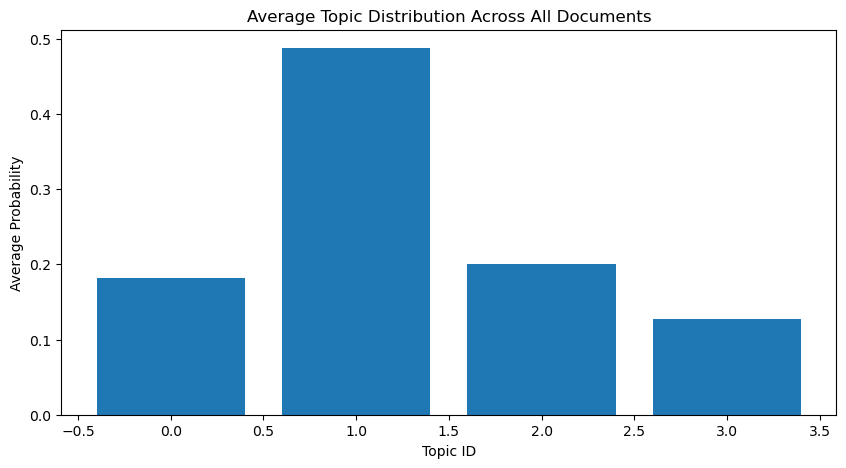

In [75]:
# Analyze document-topic distribution

def get_document_topics(lda_model, corpus):
    return [lda_model.get_document_topics(doc) for doc in corpus]

doc_topics = get_document_topics(best_lda_model, corpus)

# Calculate average topic distribution across all documents
avg_topic_dist = [0] * best_lda_model.num_topics
for doc in doc_topics:
    for topic_id, prob in doc:
        avg_topic_dist[topic_id] += prob
avg_topic_dist = [prob / len(doc_topics) for prob in avg_topic_dist]

# Plot average topic distribution
plt.figure(figsize=(10, 5))
plt.bar(range(best_lda_model.num_topics), avg_topic_dist)
plt.xlabel('Topic ID')
plt.ylabel('Average Probability')
plt.title('Average Topic Distribution Across All Documents')
plt.show()

In [76]:
# Print example documents for each topic

def print_example_docs(lda_model, corpus, texts, n_docs=2):
    for topic_id in range(lda_model.num_topics):
        print(f"Example documents for Topic {topic_id}:")
        topic_docs = sorted([(doc_id, prob) for doc_id, doc_topics in enumerate(doc_topics) 
                             for t_id, prob in doc_topics if t_id == topic_id], 
                            key=lambda x: x[1], reverse=True)
        for doc_id, prob in topic_docs[:n_docs]:
            print(f"  Document: {' '.join(texts[doc_id][:30])}...")
            print(f"  Probability: {prob:.4f}")
        print()

print_example_docs(best_lda_model, corpus, texts)

Example documents for Topic 0:
  Document: would f astarion lube protection night day kitchen floor toilet seat dining table bedroom bathroom sink shower front porch balcony vertically horizontally quadratic exponential logarithmic gasp air scream see light...
  Probability: 0.9829
  Document: tldr heavy heart must admit good time ibut mighti tldr bif enjoy crpg genre game almost certainly youb im surprised havent bought yet light near universal acclaim reading bought game...
  Probability: 0.9766

Example documents for Topic 1:
  Document: anticipated game since chess best thing according internet happened world since invention wheel actually good duke nukem forever roleplaying game lady gentleman everybody twentytwo long year ibaldurs gate iiii century...
  Probability: 0.9939
  Document: normal circumstance like finish game review however normal circumstance rather abnormal circumstance get okay might exaggerating still even though im part way third act game want get review done wan

In [5]:
# Function to clean text
def clean_text(text):
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text)
    text = text.lower().strip()
    return text

# Apply the text cleaning function to the 'review' column
new_df_positive['cleaned_review'] = new_df_positive['review'].apply(clean_text)

# Function to tokenize text
def tokenize_text(text):
    return word_tokenize(text)

# Tokenize the cleaned reviews
new_df_positive['tokenized_review'] = new_df_positive['cleaned_review'].apply(tokenize_text)

# Create bigram model
bigram = Phrases(new_df_positive['tokenized_review'], min_count=5, threshold=100)
bigram_mod = Phrases([bigram[doc] for doc in new_df_positive['tokenized_review']])

# Apply the bigram model to our tokenized reviews
new_df_positive['bigram_review'] = new_df_positive['tokenized_review'].apply(lambda x: bigram_mod[x])

# Initialize stopwords
stop_words = set(stopwords.words('english'))

# Remove stopwords
new_df_positive['bigram_review'] = new_df_positive['bigram_review'].apply(lambda x: [word for word in x if word not in stop_words])

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# Apply lemmatization: choose between bigram or trigram models
new_df_positive['lemmatized_review'] = new_df_positive['bigram_review'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

additional_words = ['game', 'like', 'level', 'play', 'baldurs_gate', 'larian', 'f', 'im', 'dont']
stop_words.update(additional_words)

# Remove updated stopwords
new_df_positive['lemmatized_review'] = new_df_positive['lemmatized_review'].apply(lambda x: [word for word in x if word not in stop_words])

dictionary = Dictionary(new_df_positive['lemmatized_review'])
new_df_positive['bow'] = new_df_positive['lemmatized_review'].apply(lambda x: dictionary.doc2bow(x))

# Create a new TF-IDF model using the BoW corpus
tfidf_model = TfidfModel(new_df_positive['bow'].tolist(), id2word=dictionary)

# Transform the entire corpus with TF-IDF
corpus_tfidf = tfidf_model[new_df_positive['bow'].tolist()]

In [58]:
vis_data = gensimvis.prepare(best_lda_model, corpus, dictionary)

# Visualize
pyLDAvis.display(vis_data)

In [7]:
lda_model = LdaModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=6, random_state=42)

corpus = new_df_positive['bow'].tolist()
# Prepare visualization data
vis_data = gensimvis.prepare(lda_model, corpus, dictionary)

# Visualize
pyLDAvis.display(vis_data)

In [11]:
from transformers import pipeline
from collections import Counter
import matplotlib.pyplot as plt

In [13]:
def zero_shot_topic_classification(reviews, candidate_labels):
    classifier = pipeline("zero-shot-classification",
                          model="facebook/bart-large-mnli")
    
    results = []
    for review in reviews:
        result = classifier(review, candidate_labels, multi_label=True)
        results.append(result['labels'][0])  # Get the top predicted label
    
    return results

In [15]:
candidate_labels = ["gameplay", "story", "characters", "graphics", "performance", "combat"]

In [17]:
positive_topics = zero_shot_topic_classification(new_df_positive['cleaned_review'].tolist(), candidate_labels)
negative_topics = zero_shot_topic_classification(new_df_negative['cleaned_review'].tolist(), candidate_labels)

ValueError: You must include at least one label and at least one sequence.